In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import matplotlib.pyplot as plt
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="2"
%matplotlib inline

### Utils

In [2]:
def load_dataset(batchSize, imgSize):
    transform=transforms.Compose([
                        transforms.Scale(imgSize),
#                         transforms.Resize(imgSize),
#                         transforms.RandomRotation(degrees=(90, 180, 270)), #ignore; manually resized
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])
    path = './TilesetInput/dataset'
    dataset = dsets.ImageFolder(root=path, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=0, drop_last=True)
    
    return dataloader


def noise(noiseSize):
    def _noise(batchSize):
        return torch.randn(batchSize, noiseSize, 1, 1).cuda()
    return _noise

#### Displaying random training images

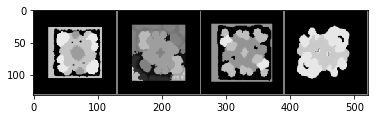

In [3]:
plotBatchSize = 4
plotImgSize = 128

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(load_dataset(plotBatchSize, plotImgSize))
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Model

In [4]:
nz  = 100 # Number of dimensions for latent Z vector
ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters
nc  = 3   # Number of channels

In [5]:
class Generator_(nn.Module):
    def __init__(self):
        super(Generator_, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(num_features=ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=ngf),
            nn.ReLU(inplace=True),            
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, input):
#         print(input)
        output = self.main(input)
#         print(output)
        return output

gnet = Generator_()
gnet = gnet.cuda()
print(gnet)

Generator_ (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh ()
  )
)


In [6]:
class Discriminator_(nn.Module):
    def __init__(self):
        super(Discriminator_, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, bias=False), 
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)        
        output = output.view(-1,1).squeeze(1)
        return output

dnet = Discriminator_()
dnet = dnet.cuda()
print(dnet)

Discriminator_ (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.2, inplace)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU (0.2, inplace)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): LeakyReLU (0.2, inplace)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (11): LeakyReLU (0.2, inplace)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Sigmoid ()
  )
)


### Optimizer

In [7]:
criterion = nn.BCELoss().cuda()
optimizer_g = optim.Adam(gnet.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_d = optim.Adam(dnet.parameters(), lr=0.0005, betas=(0.5, 0.999))

In [ ]:
# Hidden layer calculation 
batch_size = 64

import math as ma
ma.floor(ma.log(batch_size // 4, 2))

4

### Training

In [1]:
# Optional: To load saved weights
folder = 'sc_dcgan-1_out'

dnet.load_state_dict(torch.load('./{}/dnet_dict.pth'.format(folder)))
gnet.load_state_dict(torch.load('./{}/gnet_dict.pth'.format(folder)))
print("Weights loaded successfully.")

Weights loaded successfully.


In [ ]:
input_size = 100
batch_size = 64
img_size = 64
iterations = 10000
noise_z = Variable(torch.rand(batch_size, input_size, 1, 1).cuda())
folder = 'sc_dcgan-3_out'
dataloader = load_dataset(batch_size, img_size)

# Generating a log file for the status printed below
import logging
logging.basicConfig(filename='./{}/sc_dcgan-3.log'.format(folder), level=logging.INFO)
print('Started Training')
logging.info('Started Training')


# Training Loop
for epoch in range(10001):
    for i, data in enumerate(dataloader, 0):

        # Discriminator Training
        #
        dnet.zero_grad()
        # real training
        inputs_d, _ = data
        inputs_d = Variable(inputs_d.cuda())
        # print(inputs_d.data.shape)
        
        outputs_d = dnet(inputs_d)
        # print(outputs_d.data.shape)
        loss_d_real = criterion(outputs_d, Variable(torch.ones(batch_size).cuda()))
        loss_d_real.backward()

        # fake training
        inputs_g = noise_z
        # print(inputs_g.data.shape)
        outputs_g = gnet(inputs_g)
        # detach() is used to detach the variable from its graph
        outputs_dg = dnet(outputs_g.detach())

        loss_d_fake = criterion(outputs_dg, Variable(torch.zeros(batch_size).cuda()))
        loss_d_fake.backward()
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()

        # Generator Training
        #
        gnet.zero_grad()
        outputs_dg = dnet(outputs_g)
        loss_g = criterion(outputs_dg, Variable(torch.ones(batch_size).cuda()))
        loss_g.backward()
        optimizer_g.step()
        
# Print statistics            
    if epoch % (iterations/100) == 0:
        print("Iteration {}".format(epoch))
        logging.info("Iteration {}".format(epoch))
        torchvision.utils.save_image(inputs_d.data,
                './{}/real_samples_epoch_{:05d}.png'.format(folder, epoch),
                normalize=True)
        torchvision.utils.save_image(outputs_g.data,
                './{}/fake_samples_epoch_{:05d}.png'.format(folder, epoch),
                normalize=True)

# Save checkpoints for weights
    if epoch % (iterations/10) == 0:
        torch.save(dnet.state_dict(), './{}/dnet_dict_ep{:05d}.pth'.format(folder, epoch))
        torch.save(gnet.state_dict(), './{}/gnet_dict_ep{:05d}.pth'.format(folder, epoch))
        
print('Finished Training')
logging.info('Finished Training')

Started Training
Iteration 0


In [ ]:
torch.save(dnet.state_dict(), './{}/dnet_dict.pth'.format(folder))
torch.save(gnet.state_dict(), './{}/gnet_dict.pth'.format(folder))
print("Weights saved successfully.")